In [1]:
import random
import statistics
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.interpolate import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
# from lab_functions_1 import Ax, vcgrab, Tc, Lambdacalc, dLdTfunc, dVcdrfunc
import lab_functions_1 as lf

In [2]:
import importlib
import lab_functions_1  # import the full module
importlib.reload(lab_functions_1)  # reload to pick up any recent changes

# Now import the specific functions from the freshly reloaded module
import lab_functions_1 as lf

In [5]:
kpc_to_cm = 3.0857e21
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
epsilon = 1e-5
def quadsolver(T):
    dLdT = lf.dLdTfunc(T)
    dVcdr = lf.dVcdrfunc(1*ktc,27.1*ktc,210*ktc)
    beta = (-5/12) + (1/6)*dLdT
    delta = (1/3)*dVcdr - 0.25
    discrim = (beta**2) - (4*delta)
    if discrim < 0:
        print("Discriminant is negative, returning NaN")
        return np.nan
    else:
        i = -beta + np.sqrt(discrim)
        j = -beta - np.sqrt(discrim)

    dlnT1 = (i/2)
    dlnT2 = (j/2)

    T2 = T*(1 + epsilon*dlnT1)
    V1 = lf.vcgrab(1*ktc,27.1*ktc,210*ktc)
    dlnv1 = (-3/2)*(dlnT1) + 3 - (2.5*T/lf.Tc(ktc, 27.1*ktc, 210*ktc))
    V2 = V1*(1 + epsilon*dlnv1)
    mach = V2 / np.sqrt(gamma * k_Bcgs * T2 / (mu * mp_g))
    if mach > 1:
        rho1 = (3*(mu**2)*(mp_g**2)*(lf.vcgrab(1*ktc,27.1*ktc,210*ktc)**3))/(2*lf.Lambdacalc(T)*ktc)
        Tnaught = T2
        vnaught = V2
        Rnaught = kpc_to_cm*(1+epsilon)
        rhonaught = rho1*((1 + epsilon*(dlnv1)))

        cs_naught = np.sqrt(gamma * k_Bcgs * Tnaught / (mu * mp_g))
        machnaught = vnaught / cs_naught
        Mdot = 4*np.pi*(Rnaught**2)*rhonaught*vnaught
        return Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot
    else:
        rho1 = (3*(mu**2)*(mp_g**2)*(lf.vcgrab(1*ktc,27.1*ktc,210*ktc)**3))/(2*lf.Lambdacalc(T)*ktc)
        Tnaught = T*(1 + epsilon*dlnT2)
        dlnv2 = (-3/2)*dlnT2 + 3 - (2.5*T/lf.Tc(ktc, 27.1*ktc, 210*ktc))
        vnaught = V1*(1 + epsilon*dlnv2)
        Rnaught = kpc_to_cm*(1+epsilon)
        rhonaught = rho1*((1 + epsilon*(dlnv2)))

        cs_naught = np.sqrt((gamma * k_Bcgs * Tnaught) / (mu * mp_g))
        machnaught = vnaught / cs_naught
        Mdot = 4*np.pi*(Rnaught**2)*rhonaught*vnaught
        return Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot
print(quadsolver(830000))

(np.float64(830006.6588980436), np.float64(13821925.394483808), 3.085730857e+21, np.float64(1.9095865433244404e-26), np.float64(13795336.122149684), np.float64(1.001927410256531), np.float64(3.1581579079498636e+25))


In [39]:
def naughtcalcs(T):
    V1 = lf.vcgrab(1*ktc,27.1*ktc,210*ktc)
    dLdT1 = lf.dLdTfunc(T)
    dVcdr1 = lf.dVcdrfunc(1*ktc,27.1*ktc,210*ktc)
    INITdlnT = quadsolve(1, ((-5/12) + (1/6)*(dLdT1)), ((1/3)*(dVcdr1) - 0.25))
    INITdlnv = (-3/2)*(INITdlnT) + 0.5
    rho1 = (3*(mu**2)*(mp_g**2)*(lf.vcgrab(1*ktc,27.1*ktc,210*ktc)**3))/(2*lf.Lambdacalc(T)*ktc)

    epsilon = 1e-5

    Tnaught = T*(1 + epsilon*INITdlnT)
    vnaught = V1*(1 + epsilon*INITdlnv)
    Rnaught = kpc_to_cm*(1+epsilon)
    rhonaught = rho1*((1 + epsilon*(-2-INITdlnv)))

    cs_naught = np.sqrt(gamma * k_Bcgs * Tnaught / (mu * mp_g))
    machnaught = vnaught / cs_naught
    Mdot = 4*np.pi*(Rnaught**2)*rhonaught*vnaught
    return Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot
Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, Mdot = naughtcalcs(833300)
print(machnaught)


0.9999415388434318


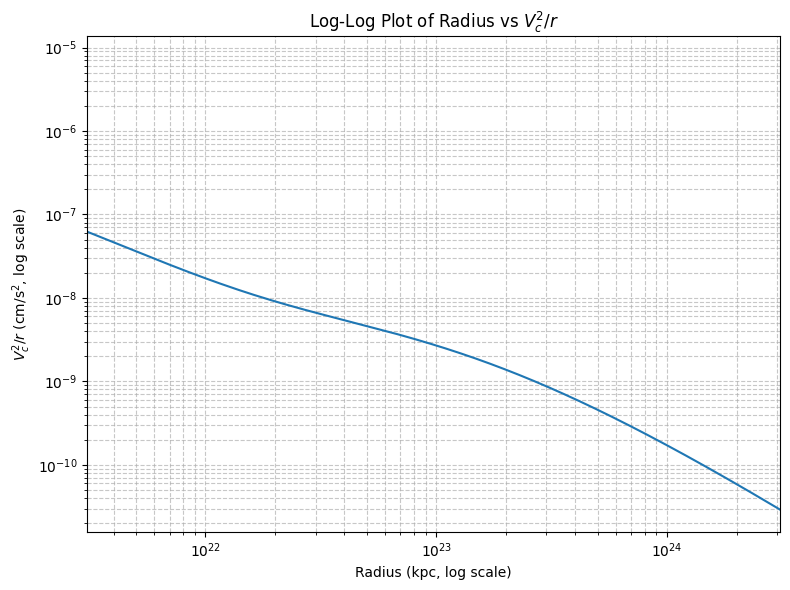

In [6]:
def vc2grab(r,rs,R):
    vc2 = lf.vcgrab(r, rs,R)**2
    return vc2/r #cm/s^2

radii = np.linspace(0.01*ktc, 1000*ktc, 4000)
vc_squared = [vc2grab(r, 27.1*ktc, 210*ktc) for r in radii]

# Plotting
plt.figure(figsize=(8, 6))
plt.loglog(radii, vc_squared)
plt.xlabel("Radius (kpc, log scale)")
plt.ylabel(r"$V_c^2/r$ (cm/s$^2$, log scale)")
plt.title("Log-Log Plot of Radius vs $V_c^2/r$")
plt.xlim(3.085e21, 3.086e24)
# plt.ylim(1e-11, 1e-6)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('plot.png', transparent=True)
plt.show()

def vc2rintfunc(r, rs, R):
    i = ktc
    a = 0.0
    dr = ktc * 0.01
    while i <= r:
        j = i + dr
        b = 0.5 * (vc2grab(i, rs, R) + vc2grab(j, rs, R))
        a += b * dr
        i += dr
    return a

In [7]:
def vc2rintfunc(r, rs, R, n):
    i = r
    a = 0.0
    dr = ktc*0.05
    while i <= n:
        j = i + dr
        b = 0.5 * (vc2grab(i, rs, R) + vc2grab(j, rs, R))
        a += b * dr
        i += dr
    return a

def phi_of_r(r_values, rs, R, n):
    phi = []
    for r in r_values:
        # Integrate from r to n
        integral = vc2rintfunc(r, rs, R, n)
        phi.append(-integral)
    return np.array(phi)

# Example usage:
r_values = np.linspace(ktc, 2100*ktc, 175)
phi_values = phi_of_r(r_values, 27.1*ktc, 210*ktc, 2500*ktc)

In [8]:
phi_interp = interpolate.interp1d(r_values, phi_values, kind='cubic', fill_value="extrapolate")

def phi(r):
    """Interpolated gravitational potential at any r."""
    return phi_interp(r)

# Example: get phi at an arbitrary r
r_test = 500 * ktc
print(f"Phi({r_test}) = {phi(r_test)}")

Phi(1.54285e+24) = -139189873998761.53


C:\Users\Jacob\AppData\Local\Temp\ipykernel_6316\962155317.py:1: DeprecationWarning: Please import `interp1d` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpolate` namespace is deprecated and will be removed in SciPy 2.0.0.
  phi_interp = interpolate.interp1d(r_values, phi_values, kind='cubic', fill_value="extrapolate")


In [ ]:
# dlnva = []
# dlnTa = []
# ra = []
# additarray = []
def TheBigOne(r, C, Mdot):
    v, T = C
    T = np.clip(T, 10**4.2, 10**8.16)
    vc2 = (lf.vcgrab(r,27.1*ktc,210*ktc)**2)
    cs2 = (gamma*k_Bcgs*T)/(mu*mp_g)
    tflow = r/np.abs(v)
    mach = (v)/np.sqrt(cs2)
    Lambda = lf.Lambdacalc(T)
    rho = Mdot/(4*np.pi*(r**2)*v)
    n = rho/(mu*mp_g)
    tcool = (3*k_Bcgs*T)/(2*Lambda*n)
    #Bern = (v**2 / 2) + (cs2*3/2) + phi(r)
    dlnvdlnr = (2 - (vc2/cs2) - (tflow/(gamma*tcool)))/(mach**2 - 1)
    dlnTdlnr = (-2/3)*(dlnvdlnr + 5*(lf.Tc(r,27.1*ktc,210*ktc))/(2*T) - 3)
    dvdr = (v/r)*dlnvdlnr
    dTdr = (T/r)*dlnTdlnr
    #dlnva.append(dlnvdlnr)
    #dlnTa.append(dlnTdlnr)
    #additarray.append(Bern)
    #ra.append(r)
    #print(f"r = {r/3.0857e21}, v2 = {v**2}, cs2 = {cs2}, phir = {phi(r)} Bern = {Bern}")
    return [dvdr, dTdr]

# V0 = vnaught
# T0 = Tnaught

# C0 = [V0, T0]

# range of r
# r_start = Rnaught
# r_end = 1000*ktc
# r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 6000)
# r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]
# # solver
# sol = solve_ivp(TheBigOne, [r_start, r_end], C0, t_eval=r_eval,
#                 method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

# plt.scatter(ra, additarray, label='Bernoulli Parameter', s=0.1)
# #plt.plot(sol.t, sol.y[1], label='T(r)')
# plt.xlabel('log(r), cm')
# plt.ylabel('value')
# #plt.yscale('log')
# plt.xscale('log')
# plt.xlim(3.08e21, 3.09e24)
# #plt.ylim(0,4)
# plt.title('v(r) and T(r) across log(r)')
# plt.legend()
# plt.grid(True)
# plt.show()

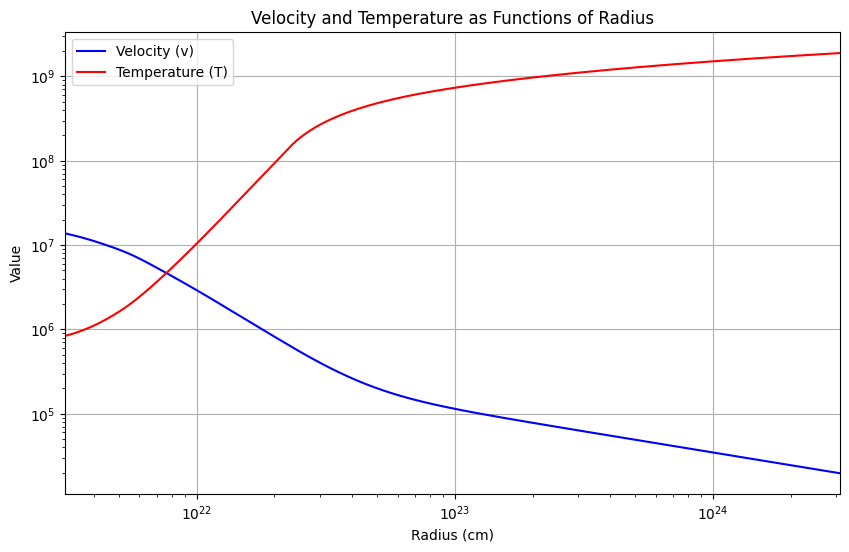

In [ ]:
def TtoSet(T):
    """Calculate the initial conditions based on a given temperature T."""
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000*ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 3000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    # Use partial to fix Mdot as an argument to TheBigOne
    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)
    return sol.t, sol.y[0], sol.y[1]
sol_t, v_sol, T_sol = TtoSet(835000)
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(sol_t, v_sol, label='Velocity (v)', color='blue')
plt.plot(sol_t, T_sol, label='Temperature (T)', color='red')
plt.xlabel('Radius (cm)')
plt.ylabel('Value')
plt.xscale('log')
plt.yscale('log')
plt.title('Velocity and Temperature as Functions of Radius')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
#plt.ylim(1e3, 1e8)
plt.savefig('velocity_temperature_plot.png', transparent=True)
plt.show()

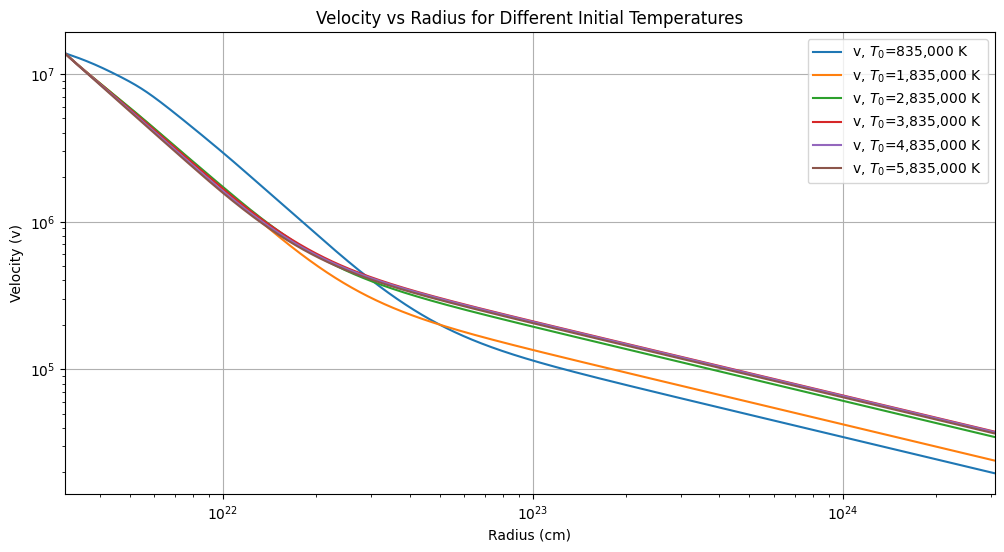

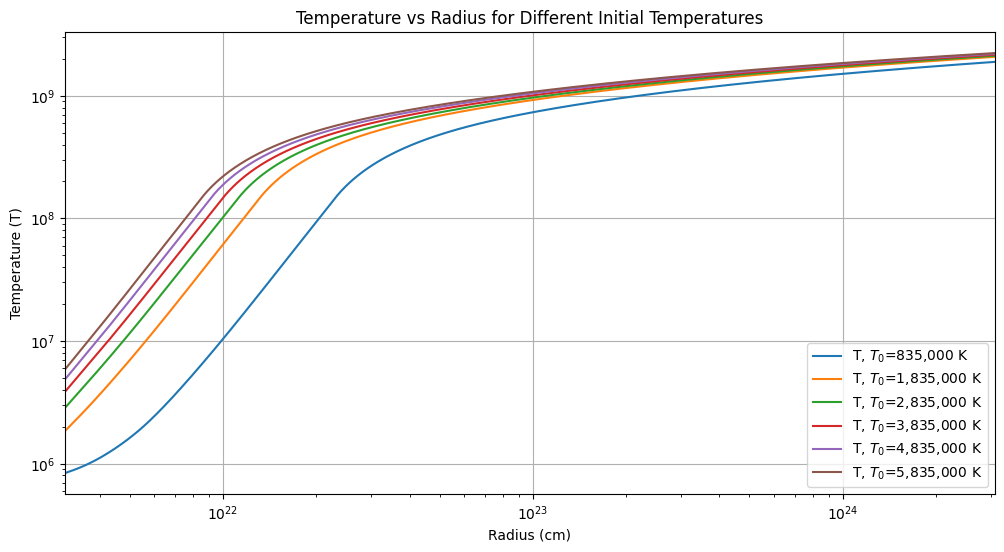

In [21]:
T_set = [835000, 1835000, 2835000, 3835000, 4835000, 5835000]
results = []

for val in T_set:
    r, v_sol, T_sol = TtoSet(val)
    results.append({'T_init': val, 'r': r, 'v': v_sol, 'T': T_sol})

# Plotting
plt.figure(figsize=(12, 6))

# Plot velocity for each initial temperature
for res in results:
    plt.plot(res['r'], res['v'], label=f'v, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Velocity (v)')
plt.xscale('log')
plt.yscale('log')
plt.title('Velocity vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.savefig('velocity_comparison.png', transparent=True)
plt.show()

plt.figure(figsize=(12, 6))

# Plot temperature for each initial temperature
for res in results:
    plt.plot(res['r'], res['T'], label=f'T, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Temperature (T)')
plt.xscale('log')
plt.yscale('log')
plt.title('Temperature vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.savefig('temperature_comparison.png', transparent=True)
plt.show()

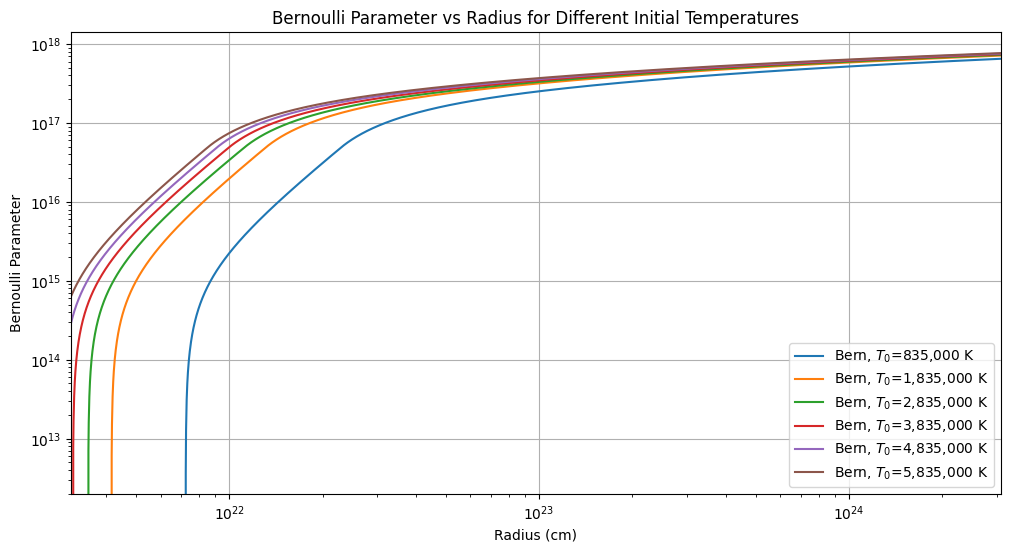

In [24]:
def TtoSet_Bern(T):
    Tnaught, vnaught, Rnaught, rhonaught, cs_naught, machnaught, _ = quadsolver(T)
    C0 = [vnaught, Tnaught]
    Mdot = 4 * np.pi * (Rnaught**2) * rhonaught * vnaught

    r_start = Rnaught
    r_end = 1000 * ktc
    r_eval = np.logspace(np.log10(r_start), np.log10(r_end), 3000)
    r_eval = r_eval[(r_eval >= r_start) & (r_eval <= r_end)]

    TheBigOne_with_Mdot = partial(TheBigOne, Mdot=Mdot)

    sol = solve_ivp(TheBigOne_with_Mdot, [r_start, r_end], C0, t_eval=r_eval,
                    method='DOP853', atol=1e-5, rtol=1e-5, dense_output=True)

    # Calculate Bernoulli parameter after integration
    v_arr = sol.y[0]
    T_arr = sol.y[1]
    Bern_arr = []
    for r, v, T in zip(sol.t, v_arr, T_arr):
        cs2 = (gamma * k_Bcgs * T) / (mu * mp_g)
        Bern = (v**2 / 2) + (cs2 * 3 / 2) + phi(r)
        Bern_arr.append(Bern)
    return sol.t, v_arr, T_arr, np.array(Bern_arr)

# Now use as before:
T_set = [835000, 1835000, 2835000, 3835000, 4835000, 5835000]
results = []

for val in T_set:
    r, v_sol, T_sol, Bern_arr = TtoSet_Bern(val)
    results.append({'T_init': val, 'r': r, 'Bern': Bern_arr})

plt.figure(figsize=(12, 6))
for res in results:
    plt.plot(res['r'], res['Bern'], label=f'Bern, $T_0$={res["T_init"]:,} K')

plt.xlabel('Radius (cm)')
plt.ylabel('Bernoulli Parameter')
plt.xscale('log')
plt.yscale('log')
plt.title('Bernoulli Parameter vs Radius for Different Initial Temperatures')
plt.legend()
plt.grid(True)
plt.xlim(3.08e21, 3.09e24)
plt.savefig('bernoulli_comparison.png', transparent=True)
plt.show()